In [28]:
#!pip install Pandas pillow tensorflow pyspark pyarrow

In [29]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Sample'
PATH_Result = PATH+'/data/results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/gaeldelescluse/Documents/OpenClassRooms/2.Projets/Projet11/ai-cloud-computing-spark/train
PATH_Data:   /Users/gaeldelescluse/Documents/OpenClassRooms/2.Projets/Projet11/ai-cloud-computing-spark/train/data/Sample
PATH_Result: /Users/gaeldelescluse/Documents/OpenClassRooms/2.Projets/Projet11/ai-cloud-computing-spark/train/data/results


In [31]:
spark = (SparkSession
             .builder
             .appName('P11')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

In [32]:
sc = spark.sparkContext

In [33]:
spark

In [35]:
# Charger les données de caractéristiques extraites précédemment
#features_df = spark.read.parquet(PATH_Result)
#features_df = spark.read.format("binaryFile") \
#  .option("pathGlobFilter", "*.jpg") \
#  .option("recursiveFileLookup", "true") \
#  .load(PATH_Data)
#features_df = features_df.withColumn('label', element_at(split(features_df['path'], '/'),-2))
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

# Convertir les fonctionnalités en vecteurs de Spark MLlib
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.withColumn("features_vector", array_to_vector_udf(col("content")))

# Standardize the data using StandardScaler
scaler = StandardScaler(inputCol="features_vector", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(features_df)
features_df = scaler_model.transform(features_df)

24/06/03 13:58:59 ERROR Executor: Exception in task 0.0 in stage 24.0 (TID 21)6]
java.lang.IllegalArgumentException: requirement failed: Dimensions mismatch when adding new sample. Expecting 5656 but got 5627.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:495)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:552)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:384)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.a

Py4JJavaError: An error occurred while calling o366.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 24.0 failed 1 times, most recent failure: Lost task 0.0 in stage 24.0 (TID 21) (192.168.0.15 executor driver): java.lang.IllegalArgumentException: requirement failed: Dimensions mismatch when adding new sample. Expecting 5656 but got 5627.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:495)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:552)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:384)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:214)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:208)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:163)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.IllegalArgumentException: requirement failed: Dimensions mismatch when adding new sample. Expecting 5656 but got 5627.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:495)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:552)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:384)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:214)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:208)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:163)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
features_df.show()

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|     features_vector|     features_scaled|
+--------------------+--------------+--------------------+--------------------+--------------------+
|file:/Users/gaeld...|Apple Braeburn|[0.41573045, 0.01...|[0.41573044657707...|[-1.7988263494666...|
|file:/Users/gaeld...|Apple Braeburn|[0.8886882, 0.041...|[0.88868820667266...|[1.43955406555597...|
|file:/Users/gaeld...|Apple Braeburn|[0.62744355, 0.01...|[0.62744355201721...|[-0.3492094235864...|
|file:/Users/gaeld...|Apple Braeburn|[0.7414025, 0.045...|[0.74140250682830...|[0.43107684828298...|
|file:/Users/gaeld...|Apple Braeburn|[0.7665582, 0.092...|[0.76655817031860...|[0.60331973094000...|
|file:/Users/gaeld...|Apple Braeburn|[0.63159835, 0.0,...|[0.63159835338592...|[-0.3207611592466...|
|file:/Users/gaeld...|Apple Braeburn|[0.47713244, 0.00...|[0.47713243961334...|[-1.37840188

In [19]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vector: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)



In [20]:
first_row = features_df.select("features_vector").first()
dense_vector = first_row["features_vector"]
dense_array = dense_vector.toArray()

image_size = (100, 100)
original_image = dense_array.reshape(image_size)

plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.show()

ValueError: cannot reshape array of size 1280 into shape (100,100)

In [7]:
num_features = len(features_df.select("features").first()[0])
print(f"Number of features: {num_features}")

rows_count = features_df.count()
print(f"Shape of features_df: ({rows_count}, {num_features + 1})")

Number of features: 1280
Shape of features_df: (10, 1281)


24/06/03 13:47:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/03 13:47:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


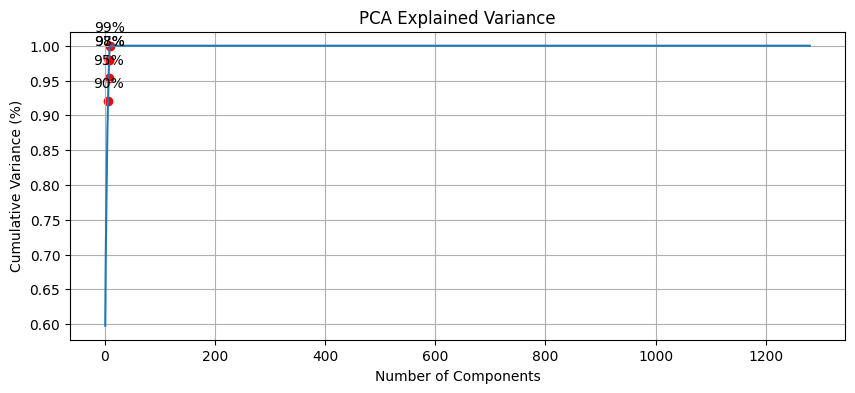

In [8]:
pca = PCA(k=num_features, inputCol="features_vector", outputCol="pca_features")
pca_model = pca.fit(features_df)

# Calculer la variance expliquée cumulée
explained_variance_ratio = pca_model.explainedVariance.cumsum()  # Variance expliquée cumulée
components = np.arange(len(explained_variance_ratio)) + 1

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(components, explained_variance_ratio, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annoter des pourcentages spécifiques de variance
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    indices = np.where(explained_variance_ratio >= threshold)[0]
    if indices.size > 0:
        component_number = indices[0]
        plt.scatter(component_number + 1, explained_variance_ratio[component_number], color='red')
        plt.annotate(f"{int(threshold*100)}%", 
                     (component_number + 1, explained_variance_ratio[component_number]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.show()

In [9]:
num_components_95_variance = np.where(explained_variance_ratio >= 0.95)[0][0] + 1
print(f"Number of components for 95% variance: {num_components_95_variance}")

Number of components for 95% variance: 7


In [10]:
pca_95 = PCA(k=num_components_95_variance, inputCol="features_vector", outputCol="pca_features_95")
pca_model_95 = pca_95.fit(features_df)
features_df_pca_95 = pca_model_95.transform(features_df)

In [12]:
# Save the PCA-transformed features
features_df_pca_95.write.mode("overwrite").parquet(PATH_Result + "_pca_95")

24/06/03 13:20:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


In [13]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [14]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------------------+--------------+
|path                                                                                   |label         |
+---------------------------------------------------------------------------------------+--------------+
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/132_100.jpg|Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/67_100.jpg |Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/311_100.jpg|Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/31_100.jpg |Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input

In [15]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [16]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [17]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [19]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [20]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/venv/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [21]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [22]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [23]:
print(PATH_Result)

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/output/Results


In [24]:
features_df.write.mode("overwrite").parquet(PATH_Result)

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step


In [56]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')
df_pca = pd.read_parquet(PATH_Result + "_pca_95", engine='pyarrow')

In [57]:
df.head()

,path,label,features
0,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.5876455, 0.0, 0.0, 0.0, 0.0, 0.1819086..."
1,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.537041, 0.0, 0.0, 0.0, 0.0, 0.03379661..."
2,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.753308, 0.0, 0.0, 0.0, 0.0, 0.03485275..."
3,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.783206, 0.0, 0.0, 0.0, 0.0, 0.21287782..."
4,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 5.169801, 0.0, 0.0, 0.010358927, 0.0, 0...."


In [58]:
df_pca.head()

,path,label,features,features_vector,features_scaled,pca_features_95
0,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 3.6077647, 0.0, 0.0, 0.0, 0.0, 0.4432928...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 5.023409, 0.0, 0.0, 0.0, 0.0, 0.19628234...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.7068405, 0.0, 0.0, 0.0, 0.0, 0.1820991...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Pineapple Mini,"[0.0, 4.8402734, 0.0, 0.0, 0.0, 0.0, 0.3369091...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P...,Cauliflower,"[0.0, 0.44653904, 2.4712944, 0.0, 0.0, 0.0, 0....","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [59]:
df_pca["features_95"] = df_pca["pca_features_95"].apply(lambda x: x["values"])

In [60]:
df_pca.iloc[0]["features_95"]

array([-5.50676093e+00,  3.83466672e+00,  5.90662172e-02, -4.99784176e+00,
        1.05262060e+00, -2.14204795e+00, -1.08324519e+00,  4.30607871e+00,
       -7.50393929e+00,  3.40671151e+00, -6.84557616e+00,  3.64785618e+00,
        3.41535568e+00,  3.09780983e-01, -1.17984413e+00,  2.82254674e+00,
       -2.98490209e+00, -4.44483116e+00,  1.78304034e+00,  1.22517722e+00,
        1.09752041e+00,  1.37239015e-01,  3.65790313e+00, -7.55426549e-01,
        8.49990189e-01,  8.66286216e-01,  2.97432680e+00,  3.33716071e+00,
       -9.14831400e-01,  7.86710220e-01,  1.25186766e+00,  1.06025695e+00,
        9.19864147e-01, -7.84024631e-01,  2.68708559e-01, -7.25464840e-01,
        3.61052440e+00,  6.95129614e-01,  5.34565996e+00, -1.11818608e+00,
       -2.94674063e+00, -1.10169778e+00,  3.39407937e+00,  3.52383169e-01,
        1.04285231e+00, -2.06360014e+00,  2.07469557e+00,  1.99425575e+00,
       -2.23899807e+00,  1.49407955e+00,  1.74104058e+00,  1.55830354e+00,
        2.05792277e+00,  

In [64]:
print("Avant", len(df_pca.iloc[0]["features"]))
print("Après", len(df_pca.iloc[0]["features_95"]))

Avant 1280
Après 328
